In [1]:
###############################################################################
# Import packages
###############################################################################
import os
import time
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from scipy.spatial.distance import cdist
import gurobipy as gp
from gurobipy import GRB
from scipy.stats import skew
import math
import itertools
from sklearn.cluster import DBSCAN

# Load functions
from helperfunctions_data_generation import generate_random_tsp_instance, fun_convert_time
from helperfunctions_data_generation import solve_tsp, plot_tsp

# **Gurobi solver**

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-04
Total costs: 226.3015346568966\Optimal solution: [(0, 1), (1, 3), (2, 0), (3, 4), (4, 5), (5, 2)]


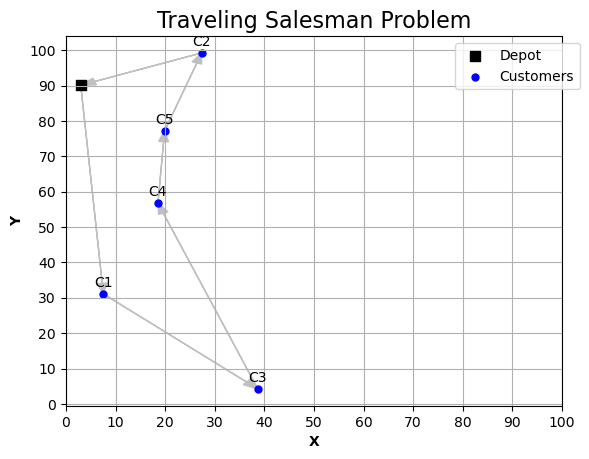

In [2]:
num_customers = 5
x_range = (0, 100)
y_range = (0, 100)

# Generate instance
tsp_instance = generate_random_tsp_instance(num_customers=num_customers, x_range=x_range, y_range=y_range)

# Extract X and Y coordinates of depot and all customers (first two columns) as tuples and give it as input for function solve_tsp
coord = [(tsp_instance['X'][i], tsp_instance['Y'][i]) for i in range(len(tsp_instance))]

# Solve TSP and receive sequence (optimal tour) and total costs as output
sequence, total_costs  = solve_tsp(coord)

# Plot TSP with optimal tour
plot_tsp(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
         assignments=None, core_point_indices=None, plot_sequence=True, print_sequence=True)

# **Concorde solver**

In [3]:
#def solve_tsp_concorde(coordinates):

In [4]:
# Solve TSP and receive sequence (optimal tour) and total costs as output
#sequence, total_costs  = solve_tsp_concorde(coord)

# **LKH heuristic**

In [5]:
#def solve_tsp_lkh(coordinates):

In [6]:
# Solve TSP and receive sequence (optimal tour) and total costs as output
#sequence, total_costs  = solve_tsp_lkh(coord)